# An exercise in generating a boundary 

Here we generate a closed boundary curve from a mask of zeros and ones indicating whether there is data.

In [1]:
using Plots

recover the donut boundary

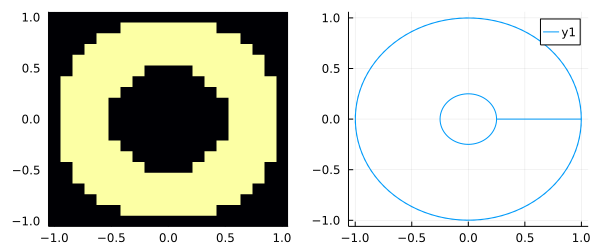

In [2]:
t1 = t2 = LinRange(-1, 1, 20)

mask = broadcast(+, t1'.^2, t2.^2) .< 1.0
mask .-= broadcast(+, t1'.^2, t2.^2) .< 0.5^2

p1 = heatmap(t1, t2, mask, colorbar = false)

t = 2*LinRange(-pi, pi, 100)
x = vcat(cos.(t), 0.5^2*cos.(t[end:-1:1]))
y = vcat(sin.(t), 0.5^2*sin.(t[end:-1:1]))


p2 = plot(x,y)

plot(p1, p2, size = (600, 250))


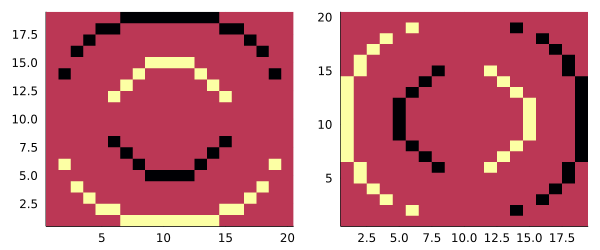

In [3]:
dif1 = diff(mask, dims = 1)
dif2 = diff(mask, dims = 2)

plot(heatmap(dif1, colorbar = false),heatmap(dif2, colorbar = false), size = (600, 250))

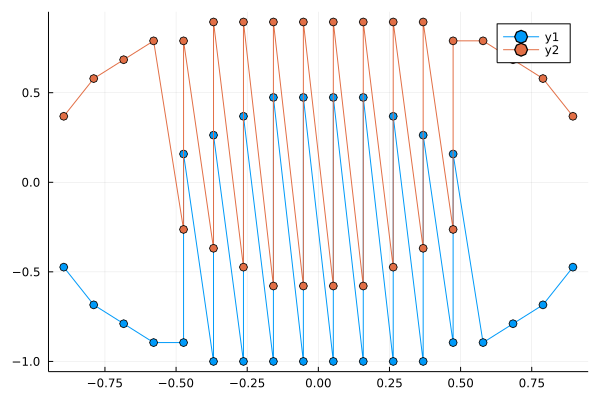

In [4]:
col1u = findall(dif1 .> 0)
col1d = findall(dif1 .< 0)

x_up = repeat(t1', length(t2), 1)
y_up = repeat(t2, 1, length(t1))

p = plot(x_up[col1u], y_up[col1u], marker = :o)
plot!(p, x_up[col1d], y_up[col1d], marker = :o)


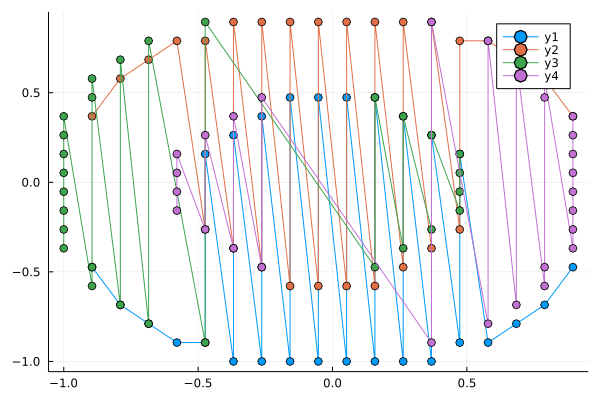

In [5]:
col2u = findall(dif2 .> 0)
col2d = findall(dif2 .< 0)

plot!(p, x_up[col2u], y_up[col2u], marker = :o)
plot!(p, x_up[col2d], y_up[col2d], marker = :o)

# Why are we zigzagging like this?

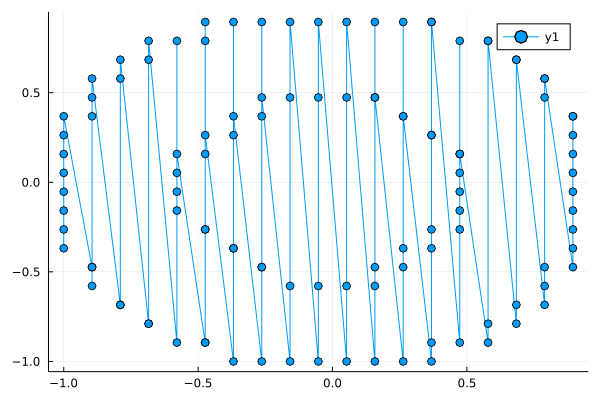

In [6]:
xp = vcat(x_up[col1u], x_up[col1d], x_up[col2u], x_up[col2d])
yp = vcat(y_up[col1u], y_up[col1d], y_up[col2u], y_up[col2d])

per = sortperm(xp)

xs = xp[per]
ys = yp[per]

plot(xs, ys, marker = :o)

In [7]:
function findnst(xs, ys, x0, y0)
    ind = findmin((xs .- x0).^2 .+ (ys .- y0).^2)[2]
    return (ind, xs[ind], ys[ind])
end

ind = zeros(Int64, length(xs))
xpath = zeros(length(xs))
xpath[1] = xs[1]
ypath = zeros(length(ys))
ypath[1] = ys[1]
compset = collect(1:length(xs))
for i = 2:length(xs)
    ind[i], xpath[i], ypath[i] = findnst(xs[compset], ys[compset], xpath[i-1], ypath[i-1])
    # xpath[i], ypath[i] = (xs[ind[i]], ys[ind[i]])
    compset = compset[1:end .!= ind[i]]
end
push!(xpath, xpath[1])
push!(ypath, ypath[1]);

In [8]:
# Approximation

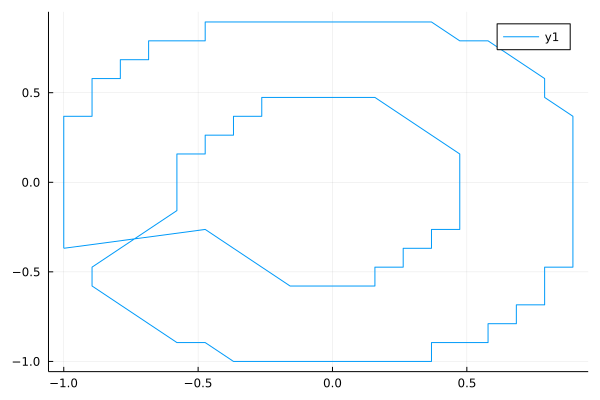

In [9]:
p = plot(xpath, ypath)

In [10]:
# Can we enforce symmetry to improve this?

In [11]:
using FastGaussQuadrature, Plots, DelimitedFiles, Random
Random.seed!(123)

include("relevant_slepian_alpha.jl")

get_quadrature_nodes_2D (generic function with 3 methods)

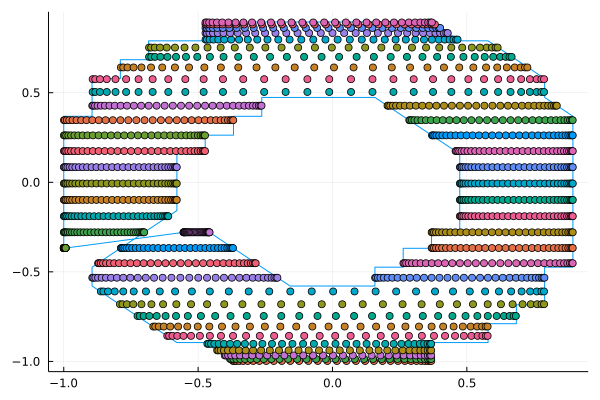

In [12]:
QX, QY, w, Nrun = get_quadrature_nodes_2D(xpath, ypath)
scatter!(p, QX, QY, legend = false)

For fun, integrate

In [13]:
using FastGaussQuadrature, Plots, DelimitedFiles, Random, Slepians, KernelMatrices, KrylovKit, IterTools, FFTW
Random.seed!(123)

include("relevant_slepian_alpha.jl")

include("../src/RHMatrix.jl")

include("ext.jl")


┌ Info: Precompiling Slepians [97caf2bd-9cc0-4738-8821-c8999f46f3c9]
└ @ Base loading.jl:1423
┌ Warning: Package Slepians does not have Statistics in its dependencies:
│ - If you have Slepians checked out for development and have
│   added Statistics as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Slepians
└ Loading Statistics into Slepians from project dependency, future warnings for Slepians are suppressed.


customsleps_ext (generic function with 1 method)

In [14]:
M  = 3
Kp = [4.0]
szs = int = (16, 16)
prec = 1e-8
exact = false
lvl = 6
maxrank = 256

no    = map(i->(QX[i], QY[i]), 1:prod(size(QX)))
sqwt = sqrt.(w[:]);

ev = vec(collect(product([range(minimum(QX), maximum(QX), length = szs[1]), range(minimum(QY), maximum(QY), length = szs[2]) ]...)))

s, sl = customsleps_ext(M, Kp, szs, prec = prec, exact = exact, lvl = lvl, maxrank = maxrank, no = no,
        sqwt = sqwt, int = nothing, ev = ev);

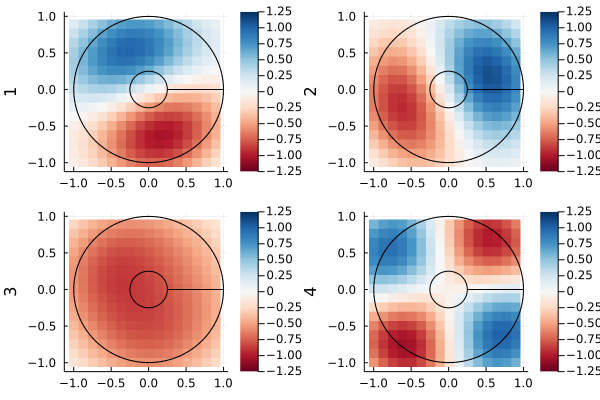

In [15]:
p1 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
p2 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
ran = 1:4
for i = ran
    p1[i] = heatmap(range(minimum(QX), maximum(QX), length = szs[1]), 
         range(minimum(QY), maximum(QY), length = szs[2]), Float64.(sl[i])',
        c = :RdBu, clims = (-1.25, 1.25), ylabel = i) # this transpose is important
    plot!(p1[i], x, y, legend = false, c = :black)

    SL = abs2.(fftshift(fft(sl[i])))
    p2[i] = heatmap(log10.(SL), ylabel = i)
end

plot(p1[ran]...)

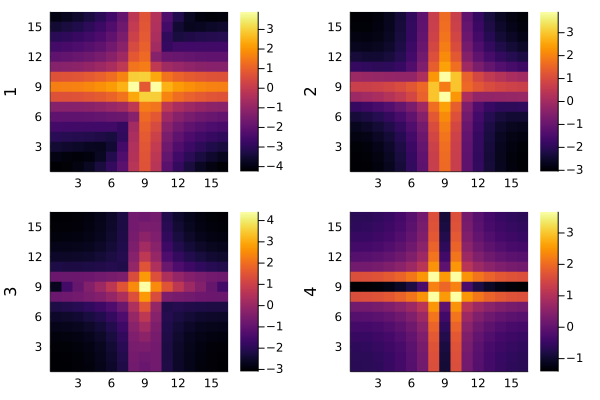

In [16]:
plot(p2[ran]...)